In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

### Getting the directories, Path and Data

In [2]:
path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"

In [3]:
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
1,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
2,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
3,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
4,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation


### Face Detection using HAAR Cascade Algorithm

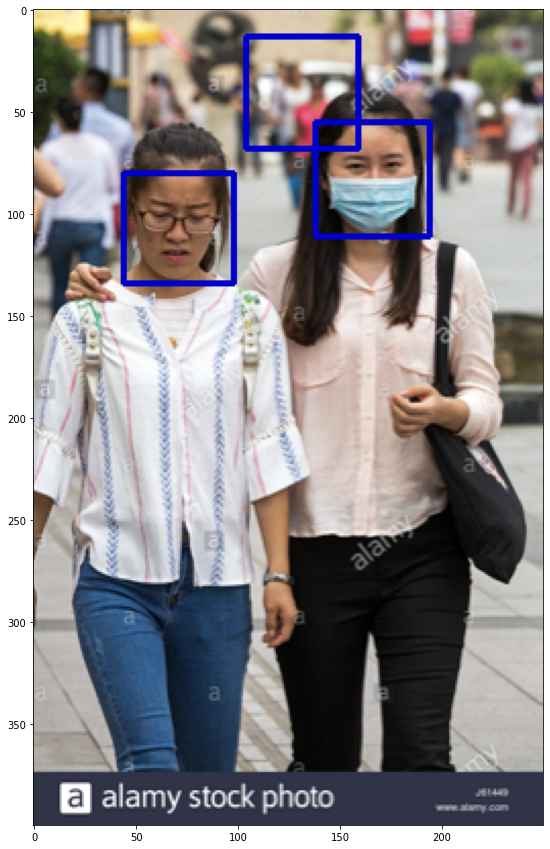

In [4]:
## Choosing a random image to detect the face in the image
face_model = cv2.CascadeClassifier('../input/haarcascades/haarcascade_frontalface_default.xml')

## Choosing the image from the directory
img = cv2.imread("../input/face-mask-detection/images/maksssksksss352.png")

## Converting the image to grayscale to apply haarcascade algorithm
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

## Returns the x, y, w, h co-ordinates as numpy arrays for all the detected faces
detected_face = face_model.detectMultiScale(img)

## Converting from grayscale to colored image
output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

## Drawing rectangle box around the faces in the image
for (x, y, w, h) in detected_face:
    cv2.rectangle(output_img, (x,y), (x+w, y+h), (0, 0, 200), 2)
    
## Displaying the image
plt.figure(figsize = (15, 15))
plt.imshow(output_img)

##### Drawbacks:

We can observe that Default face detection Haar Cascading that we choose doesnt do a good job in identifying the faces. (Will replace this with other algorithms)

### Detecting Social Distance

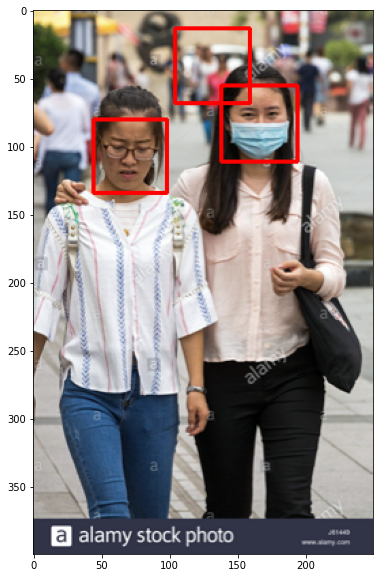

In [5]:
if len(detected_face) >= 2:
    # Track to check for violation of social distance violation
    label = [0 for i in range(len(detected_face))]
    
    # Getting the distance from one image to rest of the image  
    for i in range(len(detected_face)-1):
        for j in range(i+1, len(detected_face)):
            # [:2] gets only x, y co ordinates
            dist = distance.euclidean(detected_face[i][:2], detected_face[j][:2])
            # Checking if the distance is less than 6 feet 
            if dist < 130:
                # If less than 6 feet, flag the respective images
                label[i] = 1
                label[j] = 1
    
    # Coloring the image
    new_image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Coloring the rectangle around the image
    for i in range(len(detected_face)):
        (x, y, w, h) = detected_face[i]
        if label[i] == 1:
            # If its 1, then the distance is less than 6 feet so mark red
            cv2.rectangle(new_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        else:
            # If not mark green 
            cv2.rectangle(new_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
         
    plt.figure(figsize = (10, 10))
    plt.imshow(new_image)

Note: Red showing that they are not 6 feet apart. Green shows that they are 6 feet apart

### Visualisations

With Mask: 5909
Without Mask: 5883


<AxesSubplot:xlabel='mask_status', ylabel='count'>

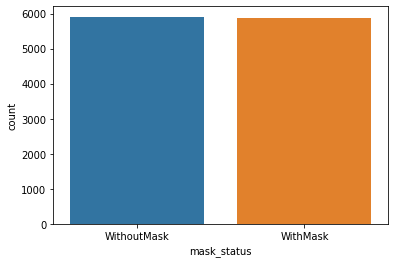

In [6]:
## Checking for total number of images in the dataset
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

## Plotting the numbers
sns.countplot(x = dataset["mask_status"])

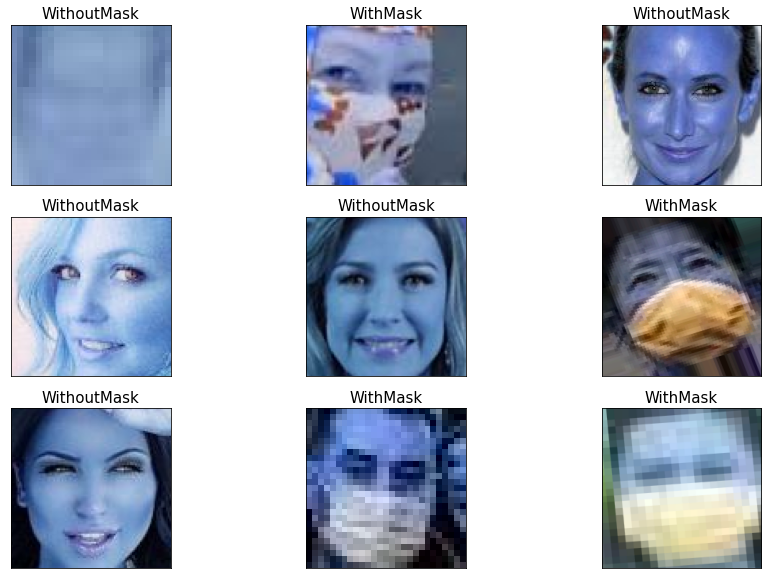

In [7]:
plt.figure(figsize = (15, 10))

for i in range(9):
    random = np.random.randint(1, len(dataset))
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random,"mask_status"], size = 15)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [8]:
## Splitting train test and Validation Dataset
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

## Shuffling the dataset 
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n After Shuffling \n")
print(train_df.head(10))

                                             image_path  mask_status  where
1792  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1793  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1794  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1795  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1796  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1797  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1798  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1799  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1800  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train
1801  ../input/face-mask-12k-images-dataset/Face Mas...  WithoutMask  Train

 After Shuffling 

                                              image_path  mask_status  where
9115   ../input/face-mask-12k-images-dataset/Face Mas...     WithMa

### Visualising the distribution of train test and validation set

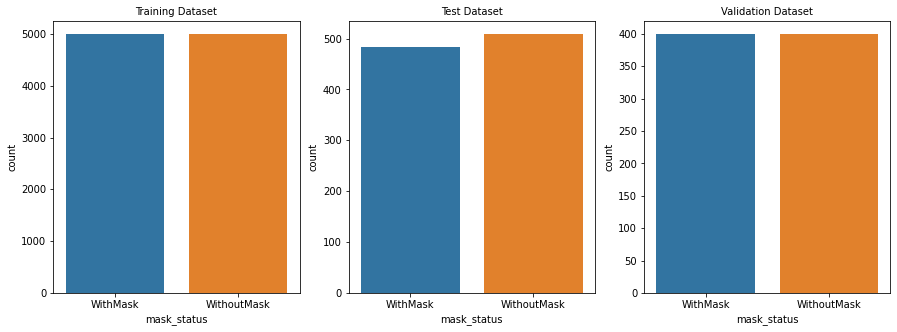

In [9]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [10]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
1,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
2,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
3,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
4,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Train


In [11]:
## Reading all the image into a list and changing the size of the image to (150,150)
data = []
image_size = 150

for i in range(len(train_df)):
    ## Converting the image into grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [12]:
data = np.array(data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [13]:
data[0][0].shape

(150, 150)

In [14]:
## Shuffling the data to make sure everything is not in order
np.random.shuffle(data)

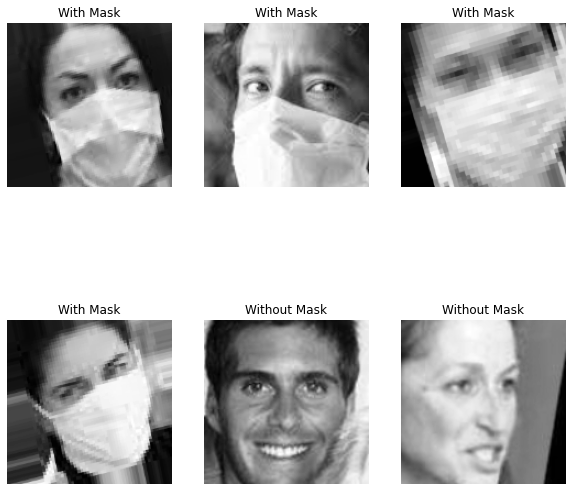

In [15]:
## Looking at the training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
            
plt.show()

In [16]:
# datagen = ImageDataGenerator(rescale = 1./255)

# train_generator=datagen.flow_from_dataframe(
# dataframe=train_df,
# directory="../input",
# x_col="image_path",
# y_col="mask_status",
# batch_size=80,
# seed=42,
# shuffle=False,
# class_mode="binary",
# target_size=(150,150))

### Preparing data to be loaded into the Model

In [17]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

In [18]:
### Normalizing the data
X = X/255

### Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Building the model

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
# model.summary()

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [21]:
# X_train = X_train.reshape(-1, 32, 150, 150)
## Reshaping training set to match Conc2D
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

history = model.fit(X_train, y_train, epochs=5, batch_size = 32)

Epoch 1/5
250/250 [==============================] - 591s 2s/step - loss: 0.6363 - accuracy: 0.7510
Epoch 2/5
250/250 [==============================] - 576s 2s/step - loss: 0.0882 - accuracy: 0.9665
Epoch 3/5
250/250 [==============================] - 581s 2s/step - loss: 0.0867 - accuracy: 0.9679
Epoch 4/5
250/250 [==============================] - 571s 2s/step - loss: 0.0461 - accuracy: 0.9846
Epoch 5/5
250/250 [==============================] - 571s 2s/step - loss: 0.0194 - accuracy: 0.9937


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (32, 148, 148, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 146, 146, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 48, 48, 64)          0         
_________________________________________________________________
flatten (Flatten)            (32, 147456)              0         
_________________________________________________________________
dense (Dense)                (32, 128)                 18874496  
_________________________________________________________________
dense_1 (Dense)              (32, 1)                   129       
Total params: 18,912,193
Trainable params: 18,912,193
Non-trainable params: 0
____________________________________________

In [23]:
model.evaluate(X_val, y_val)

63/63 [==============================] - 35s 546ms/step - loss: 0.0936 - accuracy: 0.9705


[0.09358494728803635, 0.9704999923706055]

In [24]:
prediction = model.predict_classes(X_val)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [25]:
print(classification_report(y_val, prediction))
print(confusion_matrix(y_val, prediction))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       993
           1       0.97      0.97      0.97      1007

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

[[960  33]
 [ 26 981]]
